# CV.8. 개선된 U_Net 모델 만들기
#### !Google Colab pro를 사용하여 python 3.7.13 버전에서 작성되었습니다.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!python --version

Python 3.7.13


---

### 목차
Step 0. 주요 라이브러리 import  
Step 1. KITTI 데이터셋 수집과 구축  
Step 2. U-Net++ 모델의 구현  
Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석  
회고록  
Reference  

---

### (서론)

Semantic Segmentation(시맨틱 세그멘테이션)을 이용해서 자율주행차량이 주행해야 할 도로 영역을 찾는 상황을 가정하고 U-Net과 U-Net++모델을 사용해서 이미지가 입력되면 도로의 영역을 더 정확하게 Segmentation하는 모델을 만들고자 한다.

---

### (본론)

### Step 0. 주요 라이브러리 import

- 라이브러리 가져오기

In [3]:
# 필요한 라이브러리를 로드합니다. 
import os
import math
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import plot_model

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

from albumentations import HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

print('library import success')

library import success


- GPU 연결 확인

In [10]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Step 1. KITTI 데이터셋 수집과 구축

- 다운로드한 KITTI 데이터에 data augmentation을 적용한 형태로 데이터셋을 구축.
- 주의! 
  - U-Net++는 메모리 사용량이 U-Net보다 꽤 많아짐. 
  - 그러니 배치 사이즈를 적절히 줄여서 설정.

#### 이미지, 데이터 가져오고 데이터 로더(data loader)만들기

- Semantic segmentation으로 도로의 영역을 분리하기 위해서는 도로의 영역을 라벨로 가진 데이터셋을 가지고 학습할 수 있도록 파싱해야 함.
  - 데이터셋 불러오기
    - 데이터셋 [KITTI 데이터셋의 세그멘테이션 데이터 출처](http://www.cvlibs.net/datasets/kitti/eval_semantics.php)


- 모델을 학습시킬 수 있는 데이터 로더(data loader)를 만들어 볼 예정.
  - 입력값 `(224, 224)`, 출력값 `(224,224)`크기를 갖는 모델을 학습시킬 수 있도록 데이터셋을 파싱 해야 함.
  - 이때 데이터 로더에 `albumentations` 사용해서 augmentation 적용
    - augmentation 라이브러리: albumentations, imgaug 등 `$ pip list | grep albumentations`으로 확인
    - 학습셋의 일정량을 검증 데이터셋(validation dataset) 으로 활용
[참고1](https://hwiyong.tistory.com/241)
[참고2](https://medium.com/the-artificial-impostor/custom-image-augmentation-with-keras-70595b01aeac)

In [11]:
DATA_DIR = '/content/drive/MyDrive/Colab_Notebooks/GD_08/semantic_segmentation/data'

TRAIN_PATH = os.path.join(DATA_DIR, 'training')
TEST_PATH = os.path.join(DATA_DIR, 'testing')

- 아래는 Albumentation에서 다양한 augmentation 기법을 확률적으로 적용할 수 있게 해주는 Compose()의 활용한 코드. 
- imgaug의 Sometimes()와 유사한 기능.



In [12]:
def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행
                Resize(
                    width=224,
                    height=224
                    )
                ])

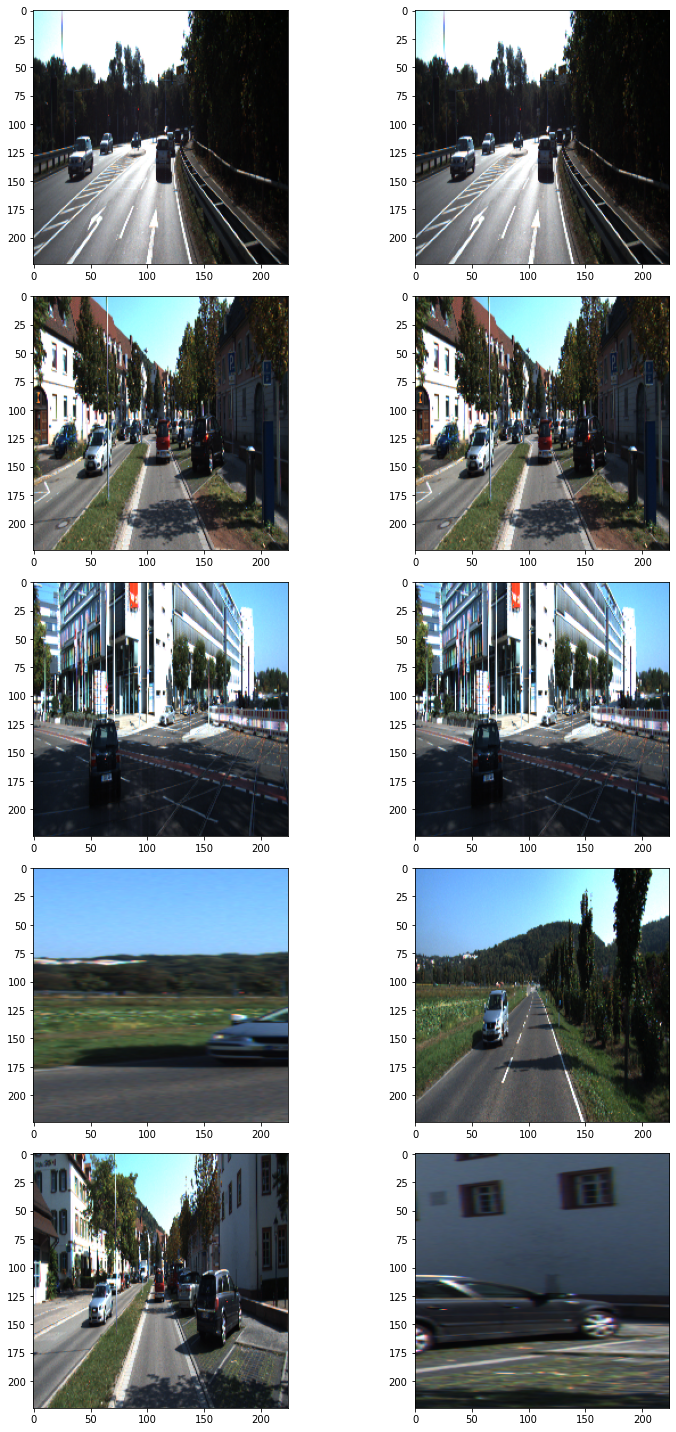

In [13]:
augmentation = build_augmentation()

input_images = glob(os.path.join(TRAIN_PATH, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지

plt.tight_layout()
plt.show()

- 아래는 데이터셋을 구성하는 코드
- 이 프로젝트에서는 `tf.keras.utils.Sequence` 를 상속받은 generator 형태로 데이터를 구성

In [14]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받음.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용함.
  '''
  def __init__(self, 
              train_path,
              batch_size=16,
              img_size=(224, 224, 3),
              output_size=(224, 224),
              is_train=True,
              augmentation=None):
    '''
    TRAIN_PATH: dataset의 directory path임.
    batch_size: batch_size임.
    img_size: preprocess에 사용할 입력이미지의 크기임.
    output_size: ground_truth를 만들어주기 위한 크기임.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받음.
    '''
    self.TRAIN_PATH = train_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.TRAIN_PATH = train_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야함.
    input_images = glob(os.path.join(self.TRAIN_PATH, "image_2", "*.png"))
    label_images = glob(os.path.join(self.TRAIN_PATH, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듬.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label임.
    batch_data = self.data[
                          index*self.batch_size:
                          (index + 1)*self.batch_size
                          ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있음.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [15]:
BATCH_SIZE = 8

In [16]:
augmentation = build_augmentation()
train_preproc = build_augmentation(is_train=True)
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    TRAIN_PATH,
    BATCH_SIZE,
    augmentation=train_preproc,
    is_train=True
)

test_generator = KittiGenerator(
    TRAIN_PATH,
    BATCH_SIZE, 
    augmentation=test_preproc,
    is_train=False
)

### Step 2. U-Net++ 모델의 구현

- U-Net의 모델 구조와 소스코드를 면밀히 비교해 보다 보면, U-Net++를 어떻게 구현할 수 있을지에 대한 방안을 떠올릴 것. 
- 이 과정을 통해 U-Net 자체에 대한 이해도도 증진. 
- 그 외 적절히 U-Net의 백본 구조, 기타 파라미터 변경 등을 통해 추가적인 성능 향상이 가능할 수도 있음.

In [17]:
EPOCHS = 100

#### U-Net 구현

- 모델 구조 만들기
    - 세그멘테이션 모델 중 구조상 비교적 구현이 단순한 `U-Net`을 구현
    - 입력 이미지의 크기는 위에서 만든 데이터셋에 맞춰서 만들어줌.
    - 사용에 필요한 레이어와 연산은 다음과 같음.
      - `Conv2D`, `Conv2DTranspose`, `MaxPooling2D`, `concatenate`
      - 필요에 따라서 Dropout등의 다른 레이어를 적용할 수도 있음.
    - 논문대로 Batch Normalization 적용

In [18]:
def conv_block(dim, x, concat_list=[], to_up_concat=False, to_pool=False):
    if to_up_concat:
        x = Conv2DTranspose(dim, 2, activation='elu', strides=(2,2), kernel_initializer='he_normal')(x)  # Up Sampling
        concat_list.append(x)
        x = concatenate(concat_list, axis = 3)  # Skip Connection

    x = Conv2D(dim, 3, activation='elu', padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)  # x = Dropout(0.5)(x)
    x = Conv2D(dim, 3, activation='elu', padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)  # x = Dropout(0.5)(x)

    if to_pool:
        x = MaxPooling2D(pool_size=(2, 2))(x)  # Down Sampling

    return x


def get_model_outputs(x):
    x = Conv2D(2, 3, activation='elu', padding='same',kernel_initializer='he_normal')(x)     
    x = Conv2D(1, 1, activation='sigmoid')(x)

    return x

In [19]:
def build_unet(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    filter_list = [64,128,256,512,1024]

    # Contracting Path (Left)
    conv1 = conv_block(filter_list[0], inputs)
    conv2 = conv_block(filter_list[1], conv1, to_pool=True)
    conv3 = conv_block(filter_list[2], conv2, to_pool=True)
    conv4 = conv_block(filter_list[3], conv3, to_pool=True)

    conv5 = conv_block(filter_list[4], conv4, to_pool=True)  # (Middle)

    # Expanding Path (Right)
    conv6 = conv_block(filter_list[3], conv5, [conv4], to_up_concat=True)
    conv7 = conv_block(filter_list[2], conv6, [conv3], to_up_concat=True)
    conv8 = conv_block(filter_list[1], conv7, [conv2], to_up_concat=True)
    conv9 = conv_block(filter_list[0], conv8, [conv1], to_up_concat=True)

    outputs = get_model_outputs(conv9)

    # U-Net 생성
    model = Model(inputs = inputs, outputs = outputs)
    return model

- 모델 생성

In [20]:
unet = build_unet()

- 모델 구조

In [21]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

- 모델 구조 시각화

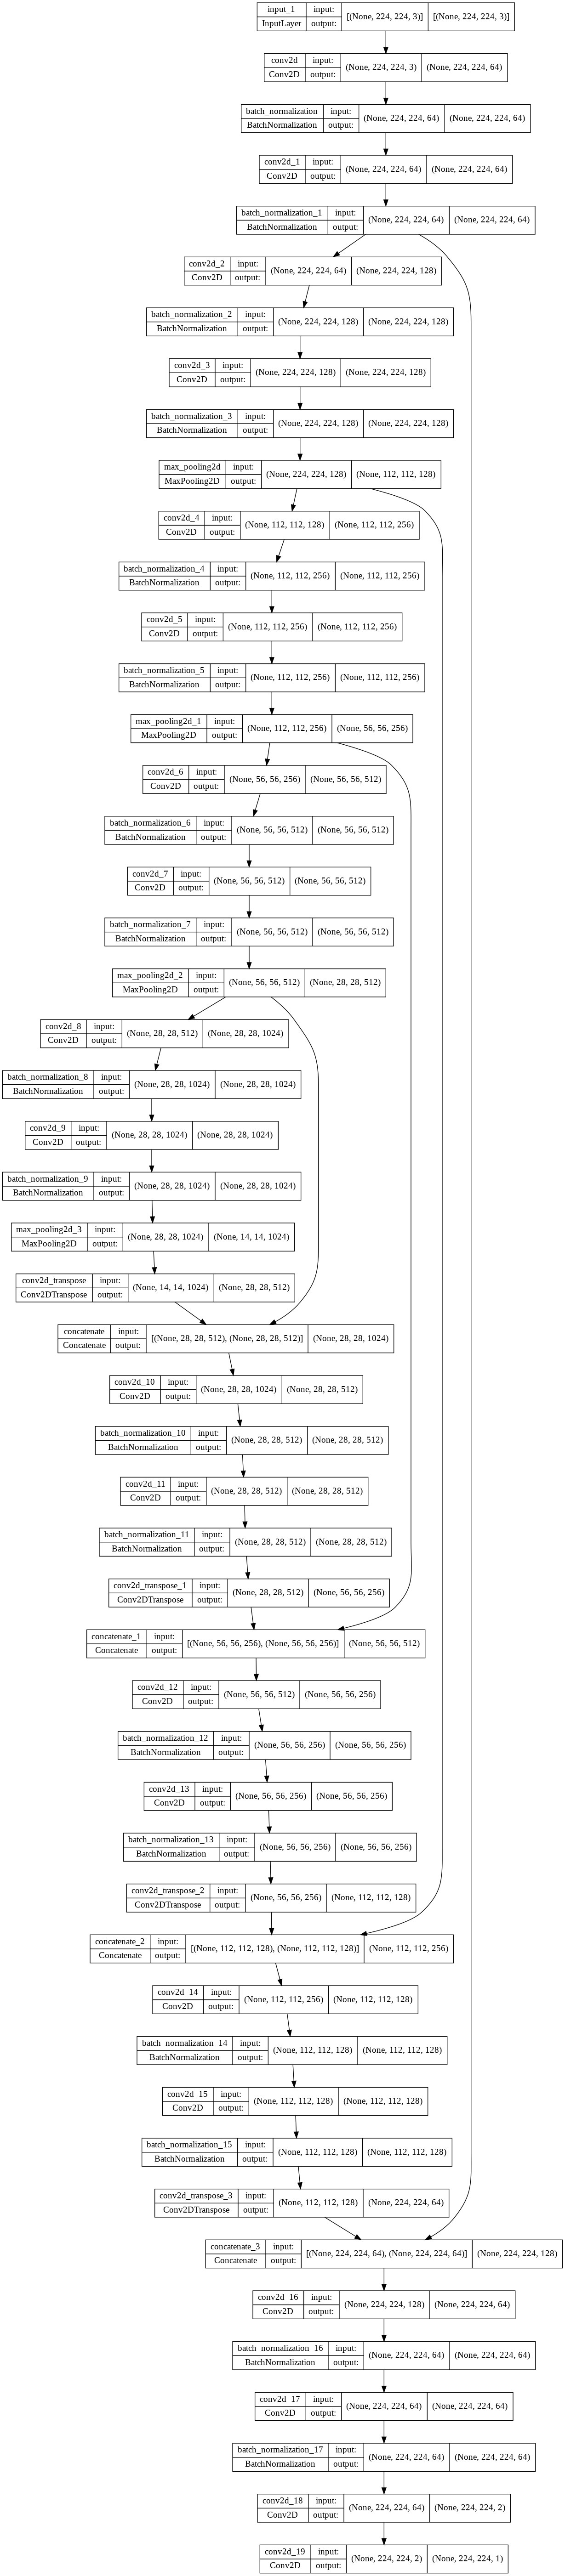

In [22]:
plot_model(unet, to_file=os.path.join(DATA_DIR, f'U-Net_shapes.png'), show_shapes=True)

- 모델 학습

In [23]:
unet.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy', metrics=['accuracy'])
unet_history = unet.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
)

Epoch 1/100
22/22 [==============================] - 26s 469ms/step - loss: 0.8296 - accuracy: 0.5597 - val_loss: 0.7919 - val_accuracy: 0.4713
Epoch 2/100
22/22 [==============================] - 7s 332ms/step - loss: 0.6777 - accuracy: 0.7988 - val_loss: 0.7946 - val_accuracy: 0.4800
Epoch 3/100
22/22 [==============================] - 7s 333ms/step - loss: 0.6286 - accuracy: 0.8871 - val_loss: 0.6932 - val_accuracy: 0.5936
Epoch 4/100
22/22 [==============================] - 7s 332ms/step - loss: 0.5859 - accuracy: 0.9247 - val_loss: 0.8085 - val_accuracy: 0.4134
Epoch 5/100
22/22 [==============================] - 7s 332ms/step - loss: 0.5590 - accuracy: 0.9371 - val_loss: 0.5178 - val_accuracy: 0.8457
Epoch 6/100
22/22 [==============================] - 7s 332ms/step - loss: 0.4894 - accuracy: 0.9570 - val_loss: 0.4060 - val_accuracy: 0.9377
Epoch 7/100
22/22 [==============================] - 7s 332ms/step - loss: 0.4716 - accuracy: 0.9623 - val_loss: 0.2342 - val_accuracy: 0.965

- 학습 결과 시각화

In [24]:
def draw_unet_history(history, model_name='U-Net'):
    plt.subplots(figsize=(12,4))

    # Model Loss, Validation Loss 시각화
    plt.subplot(121)
    plt.plot(history.history['loss'], 'r')
    plt.plot(history.history['val_loss'], 'b')
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')

    # Model Accuracy, Validation Accuracy 시각화
    plt.subplot(122)
    plt.plot(history.history['accuracy'], 'r')
    plt.plot(history.history['val_accuracy'], 'b')
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')

    plt.tight_layout()
    plt.savefig(os.path.join(DATA_DIR, f'{model_name}_Result.png'))  # 저장
    plt.show()

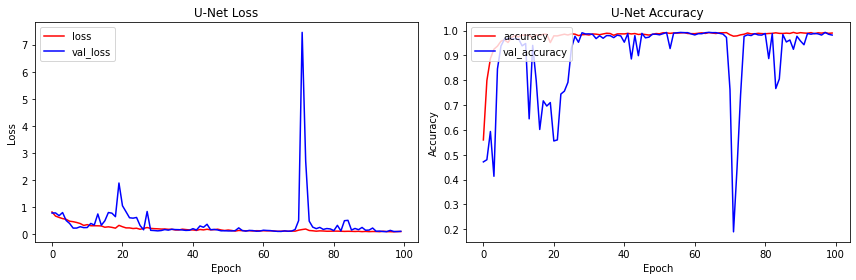

In [25]:
draw_unet_history(unet_history, 'U-Net')

- 모델 저장

In [26]:
UNET_PATH = os.path.join(DATA_DIR, 'seg_model_unet.h5')

In [27]:
unet.save(UNET_PATH)  # 학습한 모델을 저장

#### U-Net++ 구현

- 모델 구조
  - 2018년에 나온 논문.
  - 기존에 아주 단순하면서도 세그멘테이션에서 효과를 발휘했던 U-Net의 네트워크 구조에 DenseNet의 아이디어를 가미하여 성능을 개선한 모델
  - 2020년에 논문이 한 번 업그레이드 됨.
  - 모델의 구조 자체는 직관적으로 이해가 가능한 수준.
  - 앞서 구현했던 U-Net의 모델 코드를 수정해서 구하고자함.
  - [참고 Gitub](https://github.com/MrGiovanni/UNetPlusPlus)

    - `up_block` 방식: [`Transpose2D_block`](https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/segmentation_models/xnet/blocks.py#L53) 과 [`Upsample2D_block`](https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/segmentation_models/xnet/blocks.py#L28) 중 하나를 사용해서 구현.
    - [참고 paper](https://arxiv.org/pdf/1807.10165.pdf)
      - Loss를 조금 다르게 구현해야 함, binary cross-entropy 와 dice coefficient를 사용.
      - [dice_coef](https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/helper_functions.py#L37)에 구현된 dice coefficient를 참고.

In [28]:
def build_unet_pp(input_shape=(224, 224, 3), deep_supervision=True):
    inputs = Input(input_shape)

    filter_list = [64,128,256,512,1024]

    x_00 = conv_block(filter_list[0], inputs)
    x_10 = conv_block(filter_list[1], x_00, to_pool=True)
    x_20 = conv_block(filter_list[2], x_10, to_pool=True)
    x_30 = conv_block(filter_list[3], x_20, to_pool=True)
    x_40 = conv_block(filter_list[4], x_30, to_pool=True)

    x_01 = conv_block(filter_list[0], x_10, [x_00], to_up_concat=True)
    x_11 = conv_block(filter_list[1], x_20, [x_10], to_up_concat=True)
    x_21 = conv_block(filter_list[2], x_30, [x_20], to_up_concat=True)

    x_02 = conv_block(filter_list[0], x_11, [x_00,x_01], to_up_concat=True)
    x_12 = conv_block(filter_list[1], x_21, [x_10,x_11], to_up_concat=True)

    x_03 = conv_block(filter_list[0], x_12, [x_00,x_01,x_02], to_up_concat=True)

    x_31 = conv_block(filter_list[3], x_40, [x_30], to_up_concat=True)
    x_22 = conv_block(filter_list[2], x_31, [x_20], to_up_concat=True)
    x_13 = conv_block(filter_list[1], x_22, [x_10], to_up_concat=True)
    x_04 = conv_block(filter_list[0], x_13, [x_00,x_01,x_02,x_03], to_up_concat=True)

    if deep_supervision:
        x_01_outputs = get_model_outputs(x_01)
        x_02_outputs = get_model_outputs(x_02)
        x_03_outputs = get_model_outputs(x_03)
        x_04_outputs = get_model_outputs(x_04)

        outputs_list = [x_01_outputs, x_02_outputs, x_03_outputs, x_04_outputs]
        outputs = tf.keras.layers.Average()(outputs_list)  # 레이어 모든 값 평균 계산 => sum(outputs_list)/len(outputs_list) 과 결과 같음
    else:
        outputs = get_model_outputs(x_04)

    # U-Net++ 생성
    model = Model(inputs = inputs, outputs = outputs)
    return model

- 모델 생성

In [29]:
unet_pp = build_unet_pp()

- 모델 구조

In [30]:
unet_pp.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 224, 224, 64  256        ['conv2d_20[0][0]']              
 ormalization)                  )                                                           

- 모델 구조 시각화

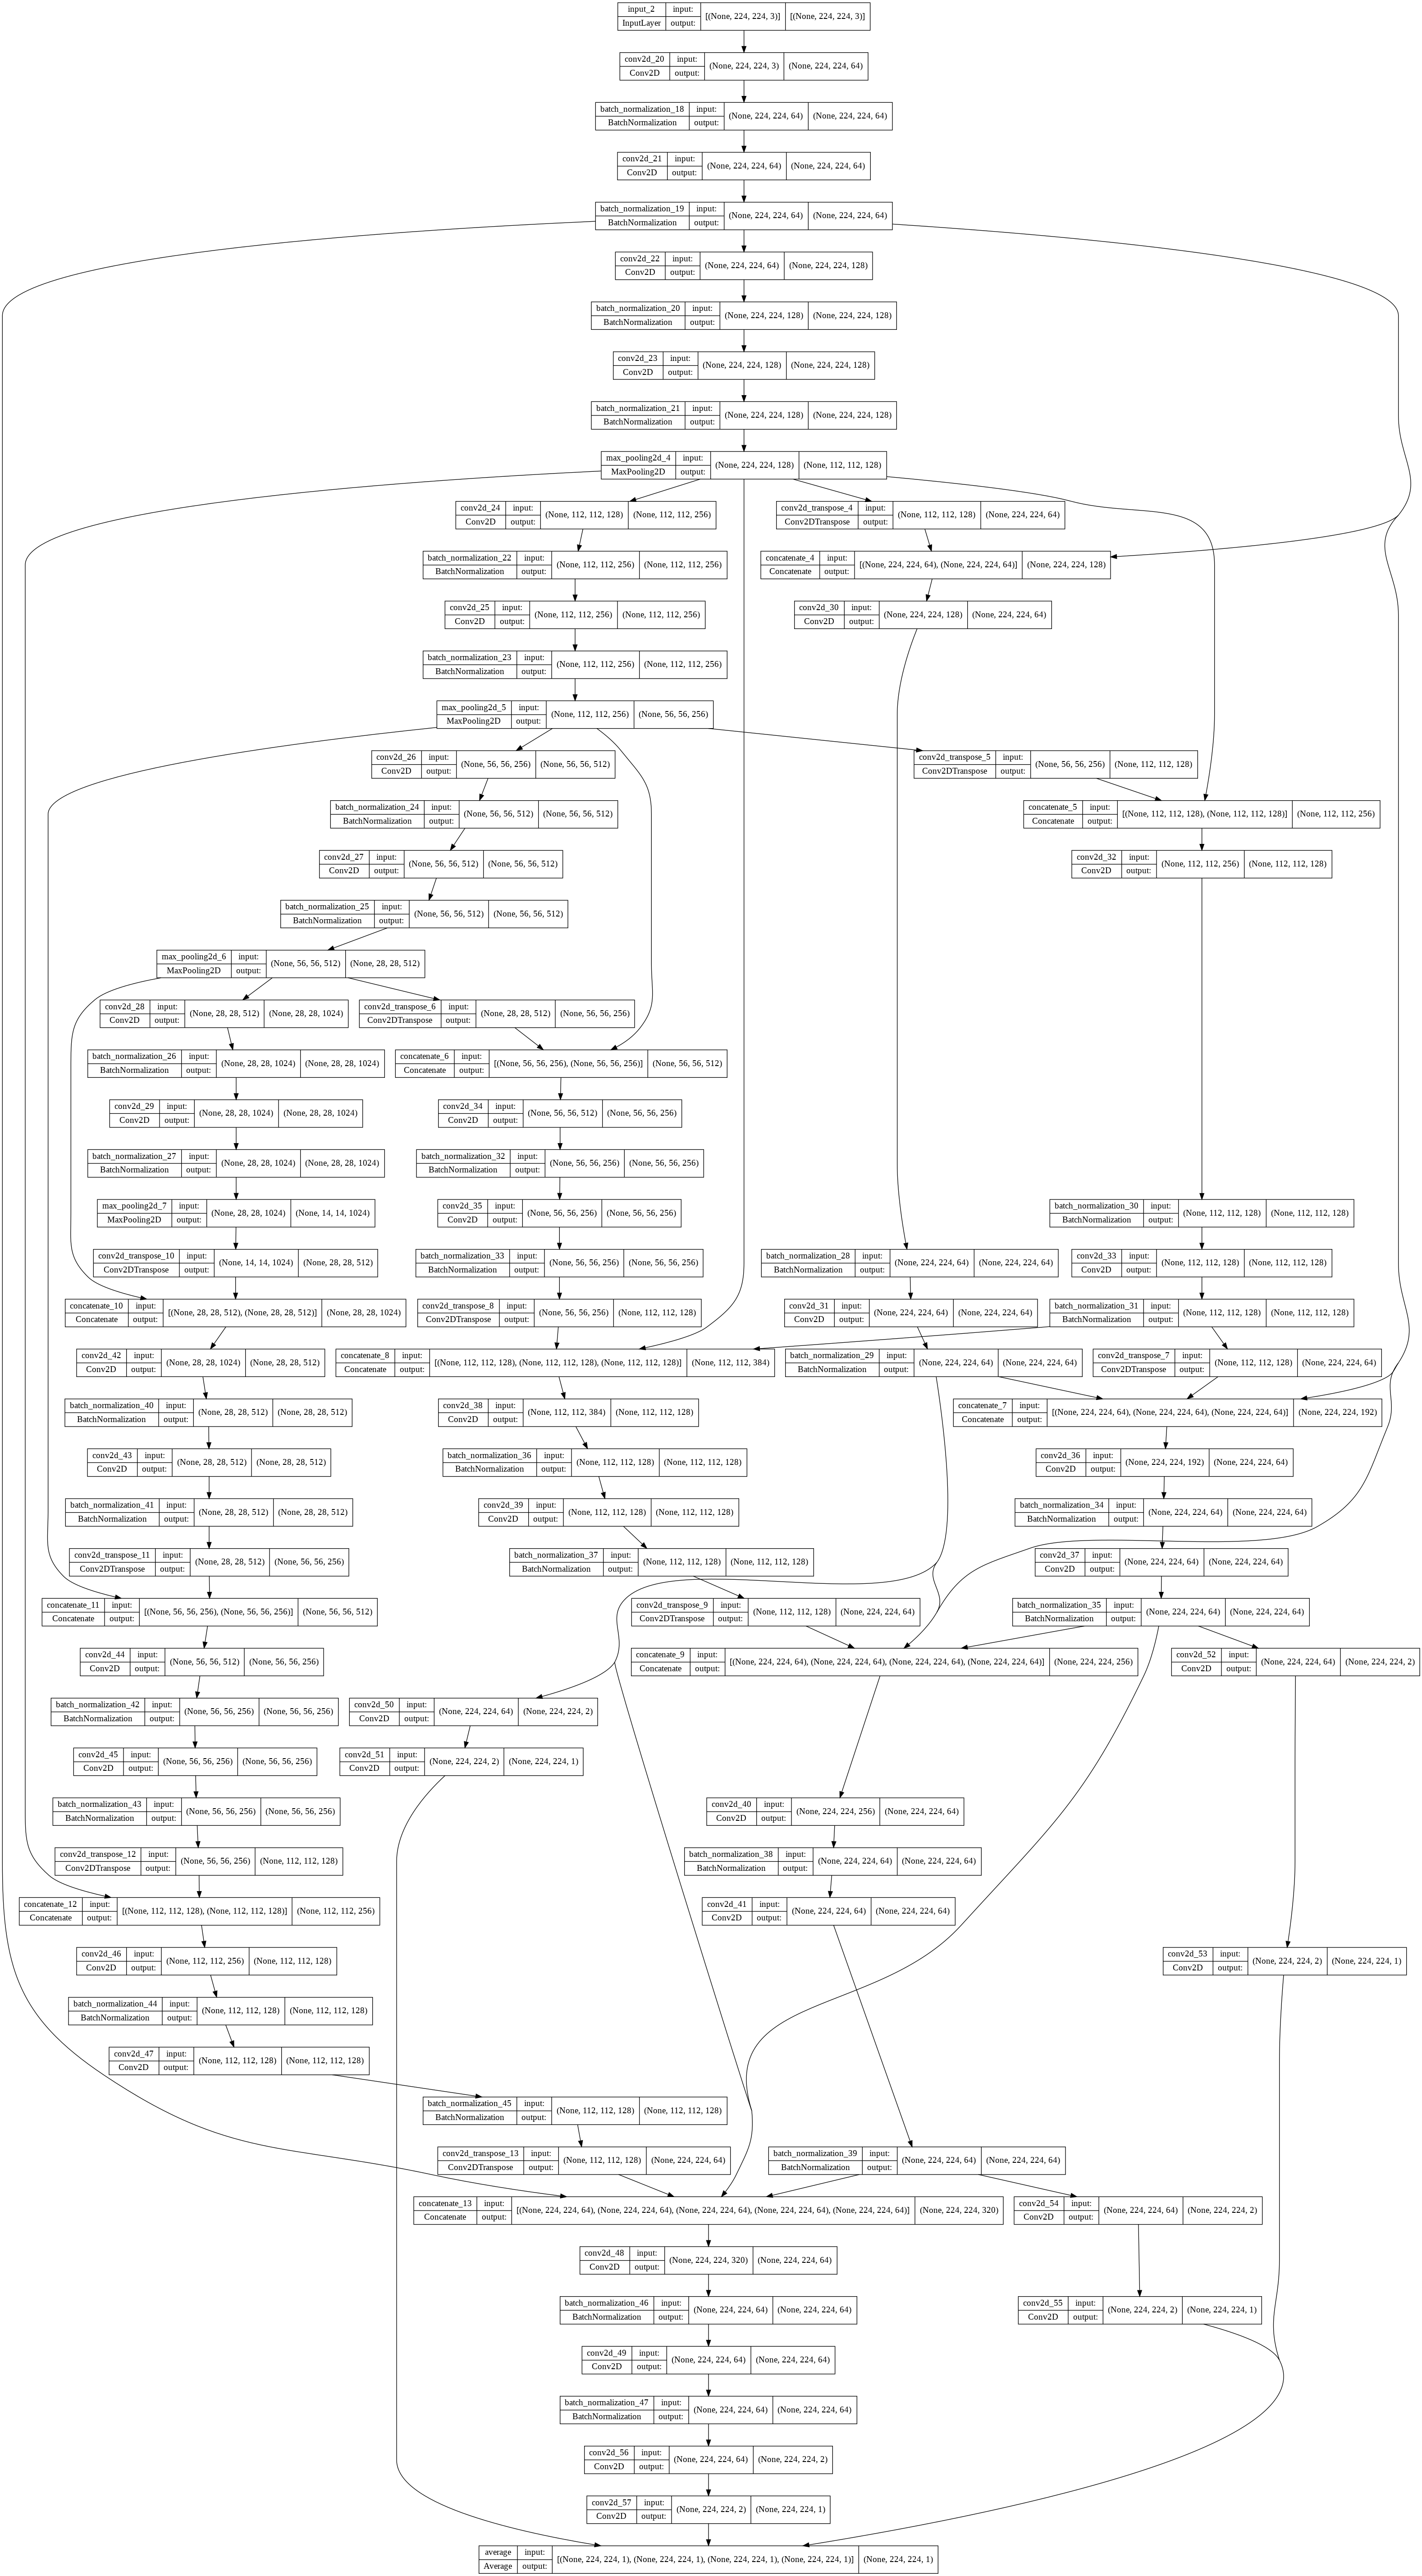

In [31]:
plot_model(unet_pp, to_file=os.path.join(DATA_DIR, f'U-Net++_shapes.png'), show_shapes=True)

- 모델 학습
  - Custom Loss 사용 [[코드 출처]](https://github.com/MrGiovanni/UNetPlusPlus/blob/master/keras/helper_functions.py)
  - Binary Cross Entropy + Dice Coefficient [[설명 출처]](https://aigong.tistory.com/154)
    - Binary Cross Entropy
      - Classification 에서 사용
      - Segmentation 에서 사용하면 물체가 작아도 Similarity 가 좋게 나오는 단점
      - 해결하기 위해 WCE(Weighted CE), BCE(Balancde CE) 사용할 수 있음
    - Dice Coefficient
      - 정답과 예측값이 완전히 같으면 1(=Dice Loss는 0), 완전히 다르면 0(=Dice Loss는 1)
      - Dice Loss
        - 정답과 예측값이 완전히 같으면 0, 완전히 다르면 1
        - 분모가 0이 되는 것을 방지하기 위해 분모, 분자에 1을 더함

In [32]:
from keras import backend as K

# Custom loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [33]:
unet_pp.compile(
    optimizer = Adam(1e-4),
    loss=bce_dice_loss,
    metrics=[dice_coef],
)

unet_pp_history = unet_pp.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
)

Epoch 1/100
22/22 [==============================] - 19s 646ms/step - loss: 0.1660 - dice_coef: 0.0879 - val_loss: 0.3223 - val_dice_coef: 0.0817
Epoch 2/100
22/22 [==============================] - 13s 611ms/step - loss: 0.0548 - dice_coef: 0.1351 - val_loss: 0.4018 - val_dice_coef: 0.0774
Epoch 3/100
22/22 [==============================] - 13s 611ms/step - loss: 0.0101 - dice_coef: 0.1611 - val_loss: 0.3659 - val_dice_coef: 0.0770
Epoch 4/100
22/22 [==============================] - 13s 610ms/step - loss: 0.0115 - dice_coef: 0.1505 - val_loss: 0.3280 - val_dice_coef: 0.0783
Epoch 5/100
22/22 [==============================] - 13s 610ms/step - loss: -0.0014 - dice_coef: 0.1549 - val_loss: 0.3000 - val_dice_coef: 0.0930
Epoch 6/100
22/22 [==============================] - 13s 610ms/step - loss: 0.0060 - dice_coef: 0.1436 - val_loss: 0.2889 - val_dice_coef: 0.0746
Epoch 7/100
22/22 [==============================] - 13s 611ms/step - loss: -0.0196 - dice_coef: 0.1603 - val_loss: 0.2840 

- 학습 결과 시각화

In [34]:
def draw_unet_history(history, model_name='U-Net'):
    plt.subplots(figsize=(12,4))

    # Model Loss, Validation Loss 시각화
    plt.subplot(121)
    plt.plot(history.history['loss'], 'r')
    plt.plot(history.history['val_loss'], 'b')
    plt.title(f'{model_name} Loss')
    plt.ylabel(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')

    # Model Dice Coef 시각화
    plt.subplot(122)
    plt.plot(history.history['dice_coef'], 'r')
    plt.plot(history.history['val_dice_coef'], 'b')
    plt.title(f'{model_name} Dice Coef')
    plt.ylabel(f'{model_name} Dice Coef')
    plt.xlabel('Epoch')
    plt.legend(['dice_coef', 'val_dice_coef'], loc='upper left')

    plt.tight_layout()
    plt.savefig(os.path.join(DATA_DIR, f'{model_name}_Result.png'))  # 저장
    plt.show()

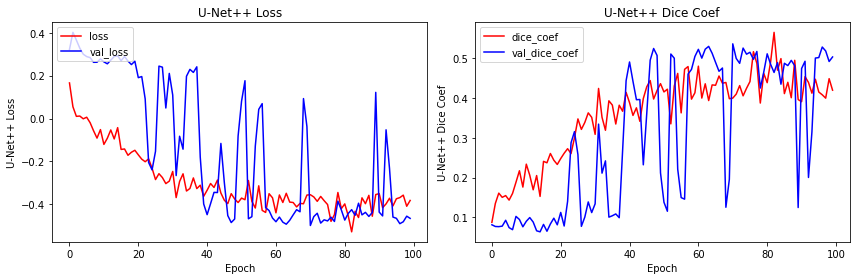

In [35]:
draw_unet_history(unet_pp_history, model_name='U-Net++')

- 모델 저장

In [36]:
UNET_PP_PATH = os.path.join(DATA_DIR, 'seg_model_unet++.h5')

In [37]:
unet_pp.save(UNET_PP_PATH)  # 학습한 모델을 저장

### Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석

- 두 모델의 정량적, 정성적 성능을 비교. 
- 시각화, IoU 계산 등을 체계적으로 시도해 보면 차이를 발견할 수 있음.

- IoU(Intersection over Union) 계산 함수
    - 세그멘테이션이 성능을 정량적으로 측정하기 위한 방법

In [38]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    return iou_score

- 모델 추론(inference) 결과 시각화 및 반환 함수
    - 모델 추론 결과 시각화(output)
        - 입력 이미지와 라벨을 한 번에 볼 수 있도록 오버레이(overray) => 세그멘테이션 이미지 생성
        - PIL 패키지 Image.blend 활용
    - 모델 추론 결과(prediction, target)
        - prediction = 모델이 도로 영역이라고 판단한 부분 1, 나머지 부분 0 인 행렬
        - target = 라벨 데이터에서 도로 영역 1, 나머지 부분 0 인 행렬
    - **[참고](https://lapina.tistory.com/81) Colab 에서는 PIL 명령어 show() 로 이미지가 열리지 않음!! => plt.show() 로 해결**
        - PIL 명령어 show(): 기본 OS에 깔린 유틸리티로 이미지를 열게 해주는 기능 => 온라인 기반 IPython에는 그런 실행이 불가능함
        - Colab, Jupyter notebook은 IPython 을 이용한 명령쉘

In [39]:
def get_output(model, preproc, image_path, output_path_dict, label_path, to_visualize=False):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  # 0.5라는 threshold를 변경하면 도로인식 결과범위가 달라짐.
    prediction = output/255   # 도로로 판단한 영역

    output_detect = Image.fromarray(output)
    output_detect = output_detect.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output_detect.save(output_path_dict['detect'], 'png')  # 저장 # 도로 detection

    background = Image.fromarray(origin_img).convert('RGBA')
    output_blend = Image.blend(background, output_detect, alpha=0.5)
    output_blend.save(output_path_dict['blend'], 'png')  # 저장 # 도로 detection + 원본 이미지

    if to_visualize:
        # 시각화 및 저장
        plt.figure(figsize=(12,6))

        plt.subplot(211)
        plt.title('Detection')
        plt.axis('off')
        plt.imshow(output_detect)

        plt.subplot(212)
        plt.title('Blend')
        plt.axis('off')
        plt.imshow(output_blend)

        plt.tight_layout()
        plt.savefig(output_path_dict['all'])  # 저장 # 이미지 2개 같이 저장
        plt.show()
    
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로(7)로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

#### U-Net 세그멘테이션 결과

- 모델 불러오기

In [40]:
unet = tf.keras.models.load_model(UNET_PATH)

- 모델 추론 결과 시각화

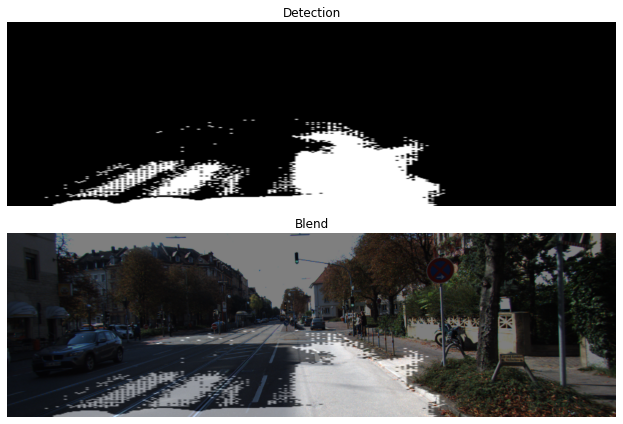

In [41]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인.
i = 1    # i값을 바꾸면 테스트용 파일이 달라짐. 
output_unet, prediction_unet, target_unet = get_output(
    unet, 
    test_preproc,
    image_path=TRAIN_PATH + f'/image_2/00{str(i).zfill(4)}_10.png',
    output_path_dict={
                      'detect': TRAIN_PATH + f'/unet_result_{str(i).zfill(3)}_detect.png',
                      'blend': TRAIN_PATH + f'/unet_result_{str(i).zfill(3)}_blend.png',
                      'all': TRAIN_PATH + f'/unet_result_{str(i).zfill(3)}_all.png',
                      },
    label_path=TRAIN_PATH + f'/semantic/00{str(i).zfill(4)}_10.png',
    to_visualize=True,
)

- IoU 계산 결과

In [42]:
unet_iou = calculate_iou_score(target_unet, prediction_unet)
unet_iou

0.3937295487405829

#### U-Net++ 세그멘테이션 결과

- 모델 불러오기
  - Custom Loss 인 bce_dice_loss() 함수를 사용했기 때문에 저장한 모델을 불러올 때 unet_pp = tf.keras.models.load_model(<model_path>) 만 쓰면 에러가 발생한다.
    - ValueError: Unknown loss function: bce_dice_loss
  - 해결 방법
    - 1) compile=False 설정
      - unet_pp = tf.keras.models.load_model(UNET_PP_PATH, compile=False)
    - 2) argument 로 custom_objects 설정 [[참고]](https://www.tensorflow.org/guide/keras/save_and_serialize)
      - unet_pp = tf.keras.models.load_model(UNET_PP_PATH, custom_objects={'dice_coef': dice_coef, 'dice_coef_loss': dice_coef_loss, 'bce_dice_loss': bce_dice_loss})

```python
# 일반적으로 모델 불러오면 에러 발생
unet_pp = tf.keras.models.load_model(UNET_PP_PATH)

# 출력된 에러
# ValueError: Unknown loss function: bce_dice_loss. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
```

```python
# 해결 방법 1
unet_pp = tf.keras.models.load_model(UNET_PP_PATH, compile=False)

# 해결 방법 2
unet_pp = tf.keras.models.load_model(UNET_PP_PATH, custom_objects={'dice_coef': dice_coef, 'dice_coef_loss': dice_coef_loss, 'bce_dice_loss': bce_dice_loss})
```


In [43]:
unet_pp = tf.keras.models.load_model(UNET_PP_PATH, compile=False)

- 모델 추론 결과 시각화

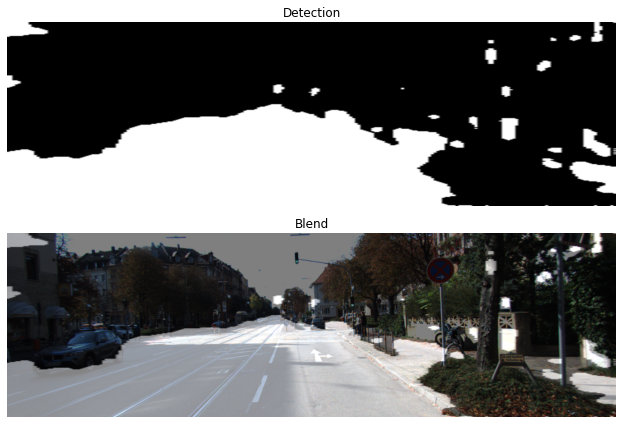

In [44]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인.
i = 1    # i값을 바꾸면 테스트용 파일이 달라짐.
output_unet_pp, prediction_unet_pp, target_unet_pp = get_output(
    unet_pp, 
    test_preproc,
    image_path=TRAIN_PATH + f'/image_2/00{str(i).zfill(4)}_10.png',
    output_path_dict={
                      'detect': TRAIN_PATH + f'/unet++_result_{str(i).zfill(3)}_detect.png',
                      'blend': TRAIN_PATH + f'/unet++_result_{str(i).zfill(3)}_blend.png',
                      'all': TRAIN_PATH + f'/unet++_result_{str(i).zfill(3)}_all.png',
                      },
    label_path=TRAIN_PATH + f'/semantic/00{str(i).zfill(4)}_10.png',
    to_visualize=True,
)

- IoU 계산 결과

In [45]:
unet_pp_iou = calculate_iou_score(target_unet_pp, prediction_unet_pp)
unet_pp_iou

0.7747830338589414

---

### 모든 테스트 이미지 결과 확인

- 추론 결과 저장 및 IoU 계산

In [46]:
def visualize_inference_and_get_iou(model, model_name='unet', to_visualize=False):
    iou = {}

    for i in range(len(os.listdir(os.path.join(TRAIN_PATH, 'image_2')))):
        output_unet, prediction_unet, target_unet = get_output(
            model, 
            test_preproc,
            image_path=TRAIN_PATH + f'/image_2/00{str(i).zfill(4)}_10.png',
            output_path_dict={
                              'detect': TRAIN_PATH + f'/{model_name}/{str(i).zfill(3)}_detect.png',
                              'blend': TRAIN_PATH + f'/{model_name}/{str(i).zfill(3)}_blend.png',
                              'all': TRAIN_PATH + f'/{model_name}/{str(i).zfill(3)}_all.png',
                              },
            label_path=TRAIN_PATH + f'/semantic/00{str(i).zfill(4)}_10.png',
            to_visualize=to_visualize,
        )

        iou[f'00{str(i).zfill(4)}_10.png'] = calculate_iou_score(target_unet, prediction_unet)

    return iou

In [47]:
unet_iou_dict = visualize_inference_and_get_iou(model=unet, model_name='unet', to_visualize=False)

In [48]:
unet_pp_iou_dict = visualize_inference_and_get_iou(model=unet_pp, model_name='unet_pp', to_visualize=False)

In [49]:
iou_all = pd.DataFrame({'unet_iou': unet_iou_dict.values(), 'unet_pp_iou': unet_pp_iou_dict.values()}, index=unet_iou_dict.keys())
iou_all

,unet_iou,unet_pp_iou
000000_10.png,0.114203,0.877684
000001_10.png,0.393730,0.774783
000002_10.png,0.280398,0.615444
000003_10.png,0.333213,0.592310
000004_10.png,0.753832,0.625861
...,...,...
000195_10.png,0.508364,0.903397
000196_10.png,0.488005,0.747296
000197_10.png,0.000075,0.013294
000198_10.png,0.000133,0.073320


- IoU 히트맵

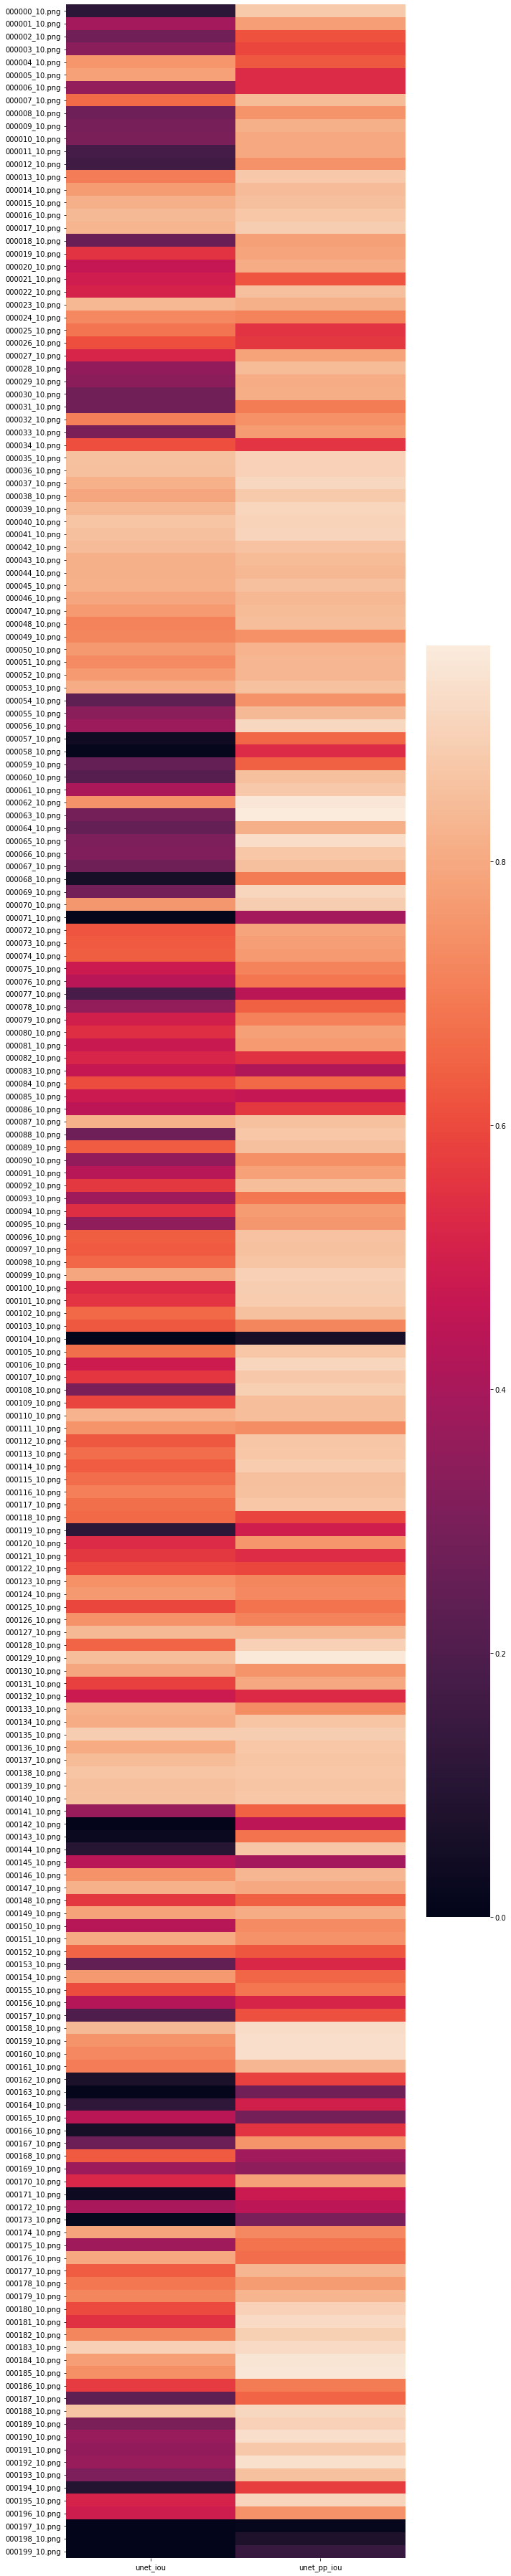

In [50]:
import seaborn as sns

plt.figure(figsize=(10,50))
sns.heatmap(iou_all)
plt.tight_layout()
plt.savefig(os.path.join(DATA_DIR, 'iou_heatmap.png'))
plt.show()

---

### (결론)

|i=1|U-Net|U-Net++|
|:---:|:---:|:---:|
|IoU<br>계산|0.393729|0.774783|

- 모델 학습을 시킬 때마다 그래프 모양이 달라짐.
- Inference 를 원본 이미지에 오버레이하여 시각화해본 결과, U-Net++ 이 segmentation영역이 더 넓은 것을 확인.
- 모델 학습을 다시 시킬 때마다 U-Net이 더 높은 iou를 갖는 경우가 있었음.
- 이를 통계적으로 비교하기 위해 Iou 히트맵을 사용한 결과 IoU 히트맵 색이 대부분 U-Net 보다 U-Net++ 이 더 연함. => 연할수록 1에 가까우므로 도로 영역을 잘 찾아낸다.
=> **대부분의 상황에서 U-Net++가 더 성능적으로 좋음.**

---

### 루브릭.

|평가문항|비고|상세기준|비고 |
|:---|:---:|:---|---:|
|U-Net을 통한 세그멘테이션 작업이 정상적으로 진행되었는가? | |KITTI 데이터셋 구성, U-Net 모델 훈련, 결과물 시각화의 한 사이클이 정상 수행되어 세그멘테이션 결과 이미지를 제출하였다. | |
|U-Net++ 모델이 성공적으로 구현되었는가? | |U-Net++ 모델을 스스로 구현하여 학습 진행 후 세그멘테이션 결과까지 정상 진행되었다. | |
|U-Net과 U-Net++ 두 모델의 성능이 정량적/정성적으로 잘 비교되었는가? | |U-Net++ 의 세그멘테이션 결과 사진과 IoU 계산치를 U-Net과 비교하여 우월함을 확인하였다. | |

---

### 회고록.

Segmentation에 대한 이해를 바탕으로 semantic segmentation을 직접 구현하여 U-Net과 U-Net++모델의 성능을 비교해보는 4번째 고잉디퍼 프로젝트였다.  
주요 세그멘테이션 모델들의 원리를 이해하는 것도 쉽지 않았다.  
Unet은 down sampling과 up sampling을 통해 검출해야하는 부분은 날려버리고 검출해야 하는 부분은 더욱 강조를 해 합쳐서 학습 데이터도 늘리고 정확도도 높인 것 같다. Unet++에서는 skipconnection의 기능을 좀더 테크니컬하게 적용하여 convolution들을 겹겹히 쌓아 마치 앙상블과 같은 효과를 얻어내 정확도를 얻어낸 것으로 보인다.  
학습을 돌릴 때마다 Unet이 iou가 더 높은 경우가 있었는데 데이터셋 문제인지 유넷 투플러스가 특정 데이터셋에서는 성능이 더 떨어지는 것인지 어떠한 원리로 더 좋은 결과를 내는 것인지 지금 당장은 이해하기 어렵다.  
이런 문제 때문인지 코드를 참고한 Github에서는 히트맵을 사용해 결과를 통계적으로 이해하기 쉽게 만든 분이 있어서 많이 배울 수 있었다.
segmentation의 원리와 종류 이를 실제 프로젝트에서 사용하기 위한 이해와 활용 능력을 기를 필요가 있음.

---

### Reference.(APA)

---